# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

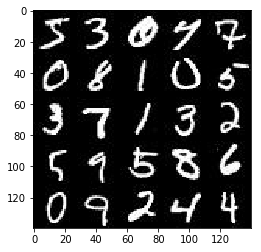

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

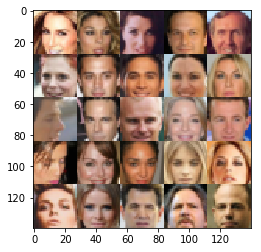

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, 1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7 x 7 x 256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same')
        # 28 x 28 x 3

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    losses = []
    #tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                #endif 
                    
                if steps % 50 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                #endif
            #end for batch_images
        #end for epoch_i
    #end with
           
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0714... Generator Loss: 3.9028
Epoch 1/2... Discriminator Loss: 0.1886... Generator Loss: 1.8627
Epoch 1/2... Discriminator Loss: 0.0105... Generator Loss: 7.0034
Epoch 1/2... Discriminator Loss: 0.0785... Generator Loss: 10.0848
Epoch 1/2... Discriminator Loss: 0.0268... Generator Loss: 4.0322


Epoch 1/2... Discriminator Loss: 0.0249... Generator Loss: 5.4664
Epoch 1/2... Discriminator Loss: 0.0424... Generator Loss: 3.4926
Epoch 1/2... Discriminator Loss: 0.0121... Generator Loss: 5.2812
Epoch 1/2... Discriminator Loss: 0.0075... Generator Loss: 5.6800
Epoch 1/2... Discriminator Loss: 0.0080... Generator Loss: 7.6024


Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 8.7730
Epoch 1/2... Discriminator Loss: 0.0111... Generator Loss: 5.3867
Epoch 1/2... Discriminator Loss: 0.0268... Generator Loss: 13.6337
Epoch 1/2... Discriminator Loss: 0.0052... Generator Loss: 6.7338
Epoch 1/2... Discriminator Loss: 0.0119... Generator Loss: 4.7993


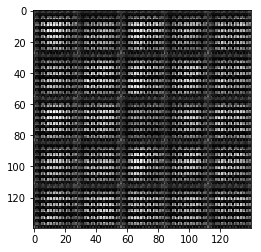

Epoch 1/2... Discriminator Loss: 0.0453... Generator Loss: 3.4026
Epoch 1/2... Discriminator Loss: 0.0808... Generator Loss: 3.4103
Epoch 1/2... Discriminator Loss: 0.1232... Generator Loss: 4.8359
Epoch 1/2... Discriminator Loss: 0.0615... Generator Loss: 3.2168
Epoch 1/2... Discriminator Loss: 0.1550... Generator Loss: 2.2915


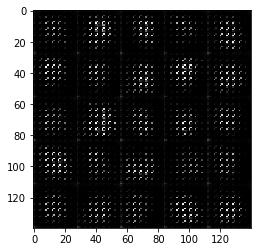

Epoch 1/2... Discriminator Loss: 0.1651... Generator Loss: 2.4007
Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 2.9694
Epoch 1/2... Discriminator Loss: 2.2746... Generator Loss: 0.2090
Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 2.4599
Epoch 1/2... Discriminator Loss: 0.4279... Generator Loss: 2.0339


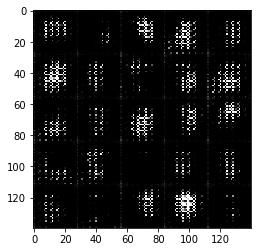

Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.0064
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 1.9999
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 1.2651
Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 1.5848
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.0247


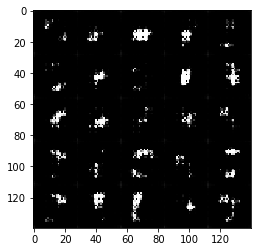

Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 1.6815
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 1.0237
Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 1.2347
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.4093


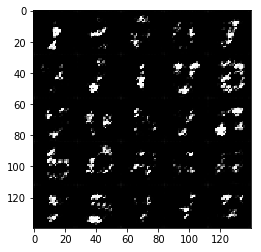

Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 0.8427... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 0.6457


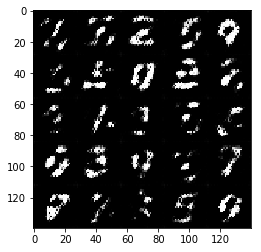

Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.2810
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.8206


Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 1.1539
Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.7718


Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 1.0181
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.5489
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 0.7126... Generator Loss: 2.0389


Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.5844
Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 2.6729


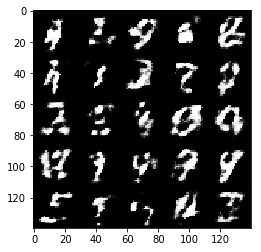

Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.5278
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 2.3013
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 0.8476
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.7833


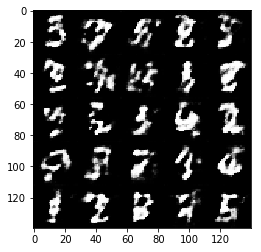

Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.9861
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.8545
Epoch 1/2... Discriminator Loss: 0.8589... Generator Loss: 1.2027


Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.6035
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.5616
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.9287


Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.9094
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.8545


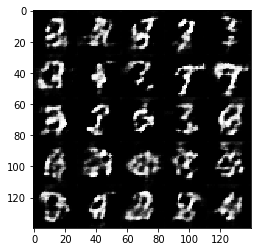

Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 1.1871
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 1.1963


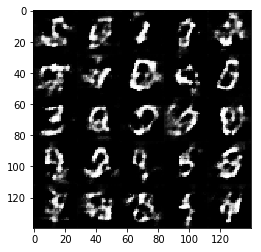

Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.8758


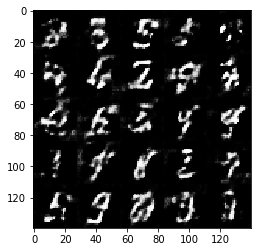

Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 1.0996
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 0.9560


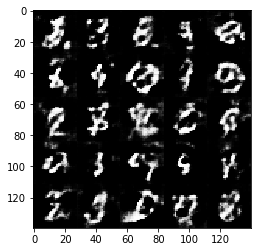

Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.9302
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 0.7915


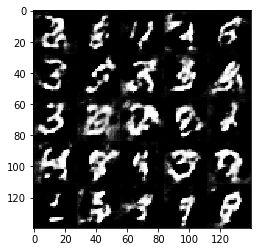

Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.0866
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 1.0681


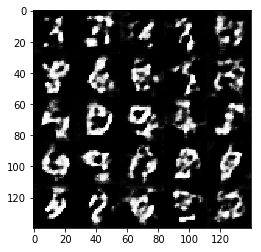

Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.9464
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.9100
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 1.0323


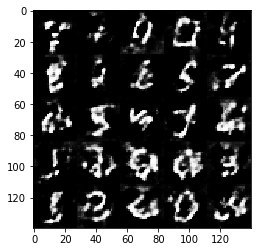

Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 1.0992
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 1.0082
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.7650


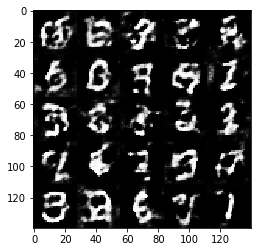

Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.8935


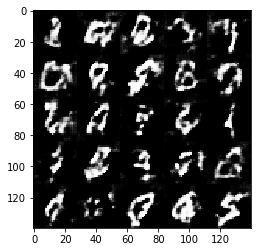

Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.2159
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 0.9822


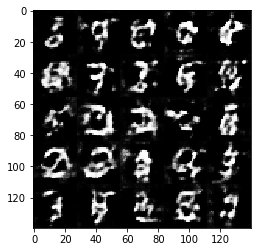

Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 1.0194
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.9529


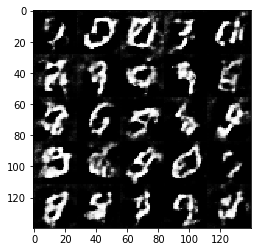

Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.9912


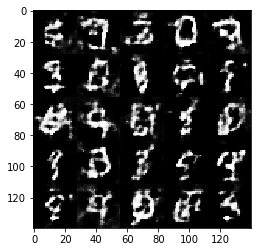

Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 1.0021
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 1.1112
Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 1.0199


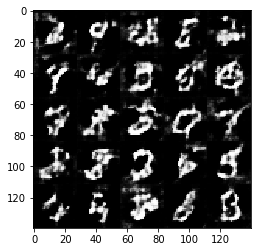

Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 1.0065
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.7739
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.0192


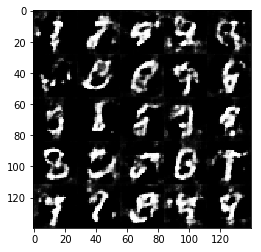

Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.0590
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 1.0722


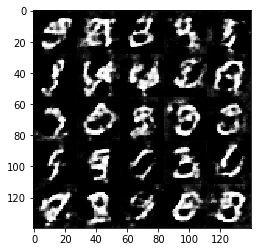

Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.0276


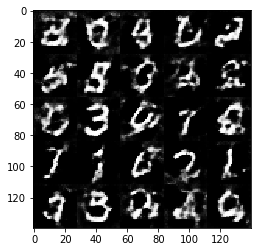

Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.8199
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 1.1972... Generator Loss: 0.7087
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 1.0181


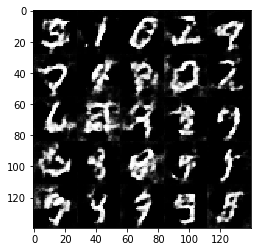

Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.9540
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 0.9261
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.9404


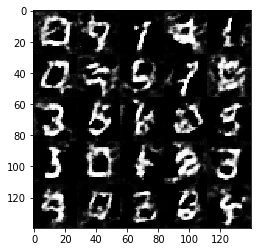

Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.7320


Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 0.8821
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.9237


Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 0.9601
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 1.0712


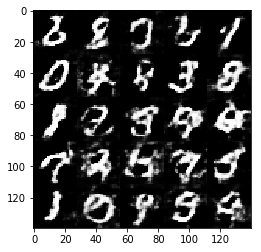

Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.9569


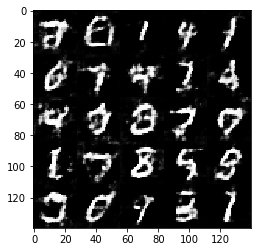

Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 0.9332


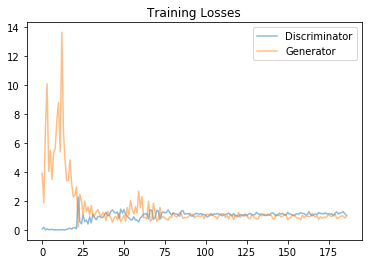

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 2.0150... Generator Loss: 0.1681
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 10.2650
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 8.3278


Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.0135... Generator Loss: 15.4601
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 5.4489
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 5.1614
Epoch 1/1... Discriminator Loss: 0.1707... Generator Loss: 1.9835


Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 5.1913
Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 4.8425
Epoch 1/1... Discriminator Loss: 0.1342... Generator Loss: 11.6349
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 4.0721
Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 2.6572


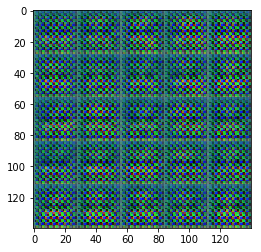

Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 4.0928
Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 2.1009
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 1.3603


Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 4.6647
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 3.7741
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 1.1263


Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 3.3102
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 2.0794
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 2.5294
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 2.2835
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 2.4038


Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 3.0393
Epoch 1/1... Discriminator Loss: 0.1437... Generator Loss: 2.8930
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.5276
Epoch 1/1... Discriminator Loss: 0.1740... Generator Loss: 3.5137
Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 2.6640


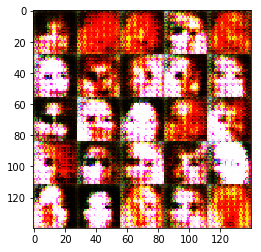

Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 3.1893
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 2.5860
Epoch 1/1... Discriminator Loss: 0.0678... Generator Loss: 4.2389
Epoch 1/1... Discriminator Loss: 0.1084... Generator Loss: 3.3548
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 3.3353


Epoch 1/1... Discriminator Loss: 0.0939... Generator Loss: 4.0365
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 5.5286
Epoch 1/1... Discriminator Loss: 0.1153... Generator Loss: 2.9449
Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 2.4823
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 2.5713


Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 4.2216
Epoch 1/1... Discriminator Loss: 0.1581... Generator Loss: 3.7403
Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 4.6909
Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 5.6347
Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 1.1606


Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 6.0186
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 4.3141
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 3.7700
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 4.9559
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.3960


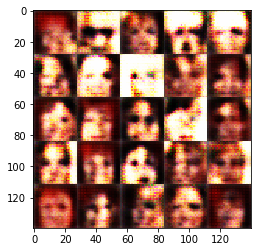

Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 1.8063
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 3.6017


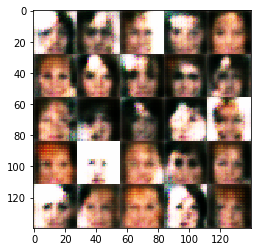

Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 4.1965
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 1.8027


Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 3.0564
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 2.3333
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.2637


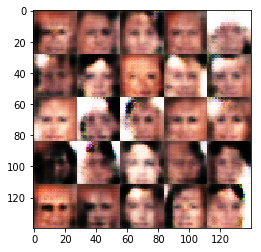

Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 1.7154
Epoch 1/1... Discriminator Loss: 0.2882... Generator Loss: 3.1697
Epoch 1/1... Discriminator Loss: 1.9542... Generator Loss: 0.2234
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.2981


Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 2.7076
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.0273


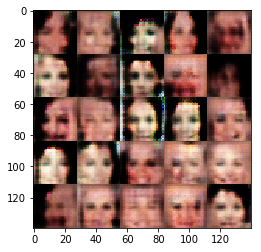

Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 3.0394... Generator Loss: 3.4432
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.1294


Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.7820... Generator Loss: 0.2653


Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 2.8793
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 1.9325... Generator Loss: 2.4126


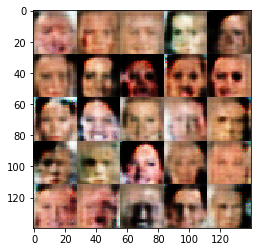

Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.5201


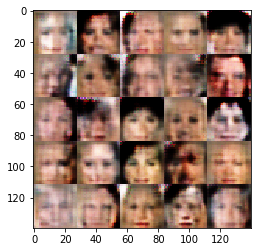

Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 1.7335... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.6957


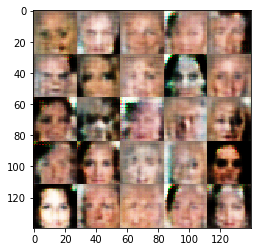

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.7357


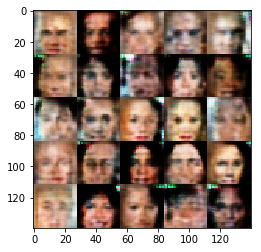

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7182


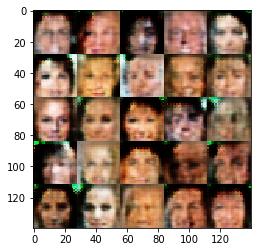

Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 5.1738


Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.2490


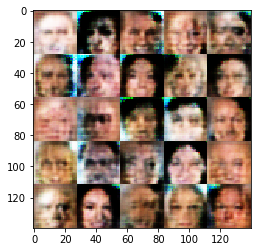

Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 2.8810
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8591


Epoch 1/1... Discriminator Loss: 2.2741... Generator Loss: 0.1452
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.3975


Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.3160


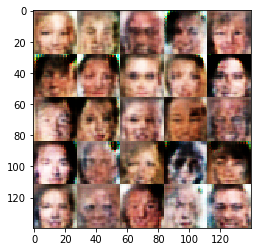

Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.5502


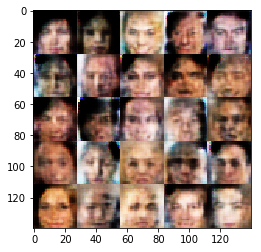

Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.5234


Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 1.0451


Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.4310


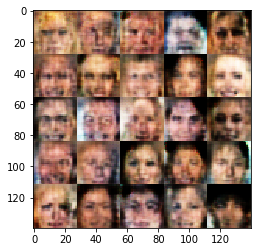

Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.9104


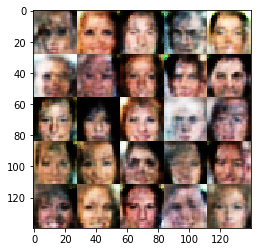

Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 2.7074... Generator Loss: 3.2249
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.4977


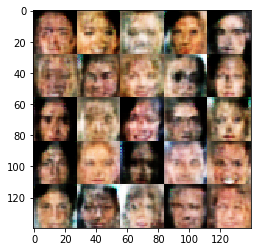

Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 0.7485


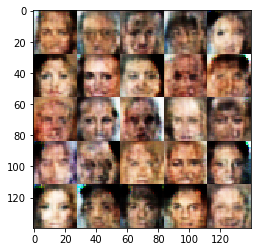

Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7150


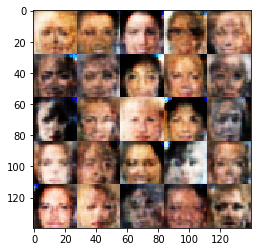

Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5135


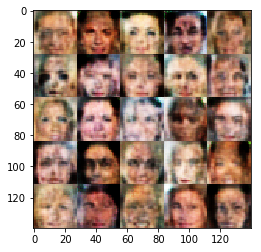

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.3650


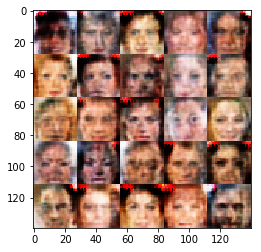

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 2.0794
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.5795


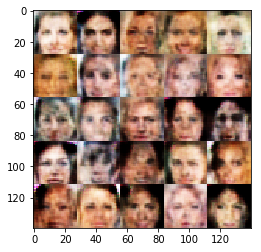

Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 1.3025


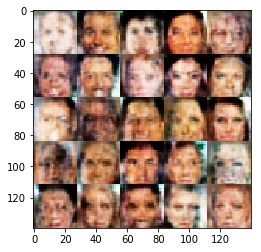

Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.9581... Generator Loss: 0.2374
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6347


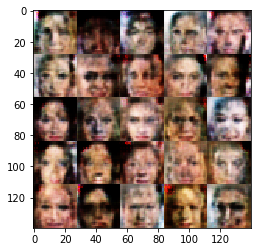

Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.0491


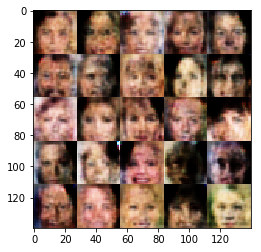

Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 1.9553


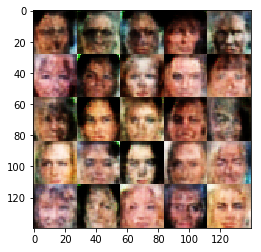

Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 1.7987
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.5445


Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.8077
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8938


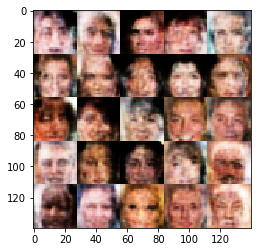

Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6754


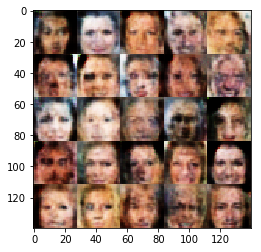

Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 3.5288
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 2.4318... Generator Loss: 3.0724
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.3314


Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 2.6334
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.4197
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.5769


Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 2.6417
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.6427
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.5102


Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.7763


Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 3.3364
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.7874


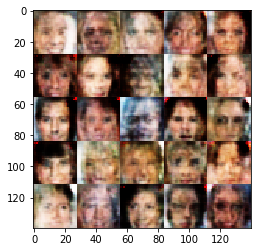

Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 2.0917... Generator Loss: 2.4255
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.3525


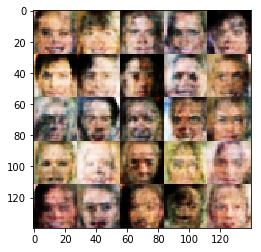

Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 1.5394


Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.4511
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.7875


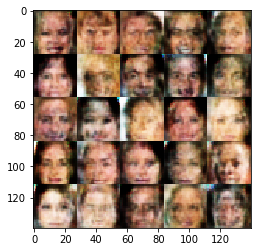

Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.0186


Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 2.3846
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.5602


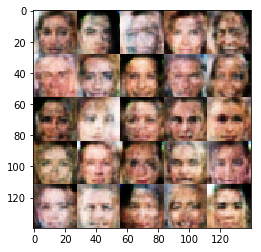

Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 1.8102
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.9388


Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.6109
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7156


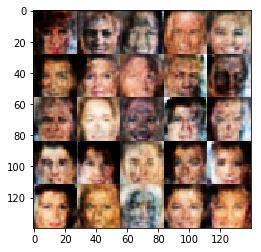

Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.7027


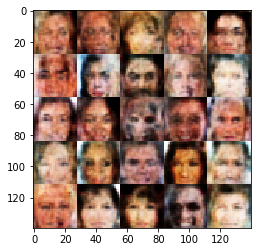

Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.1777


Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 1.7075
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.3809


Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.7420
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 2.5106
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.6115


KeyboardInterrupt: 

In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.